In [11]:
import pandas as pd
import numpy as np
import magic
from matplotlib import pyplot as plt
import seaborn as sns
import importlib
%matplotlib inline
importlib.reload(magic)
import seaborn as sns
from xgboost import XGBClassifier,XGBRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

In [12]:
csv_file = 'uber.csv'
data = pd.read_csv(csv_file)
data['tournament'] = data.tournament_scores/data.num_players
data['effectiveness'] = np.log(data.scores+1)/np.log(data.map_rivers_count/data.num_players)
data['density'] = np.log(data.map_rivers_count)/np.log(data.map_sites_count)
data['is_winner'] = data.ranking==0
params = [column for column in data.columns if column.startswith('param')]
major = ['density','num_players']
data.shape

(20136, 19)

In [13]:
len(data.name.unique())

160

In [14]:

model = XGBRegressor()
print(cross_val_score( model, data[major], data.tournament, scoring='neg_mean_absolute_error'))
print(cross_val_score( model, data[major+params], data.tournament, scoring='neg_mean_absolute_error'))

print(cross_val_score( model, data[major], data.effectiveness, scoring='neg_mean_absolute_error'))
print(cross_val_score( model, data[major+params], data.effectiveness, scoring='neg_mean_absolute_error'))

[-0.24842993 -0.2492072  -0.24886273]
[-0.24760671 -0.24839579 -0.2486281 ]
[-0.30788851 -0.32323058 -0.33217471]
[-0.30372314 -0.31144856 -0.32840518]


D:\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j
D:\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:494: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X,a,b,gridsize)/(delta*nobs)
D:\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:32: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


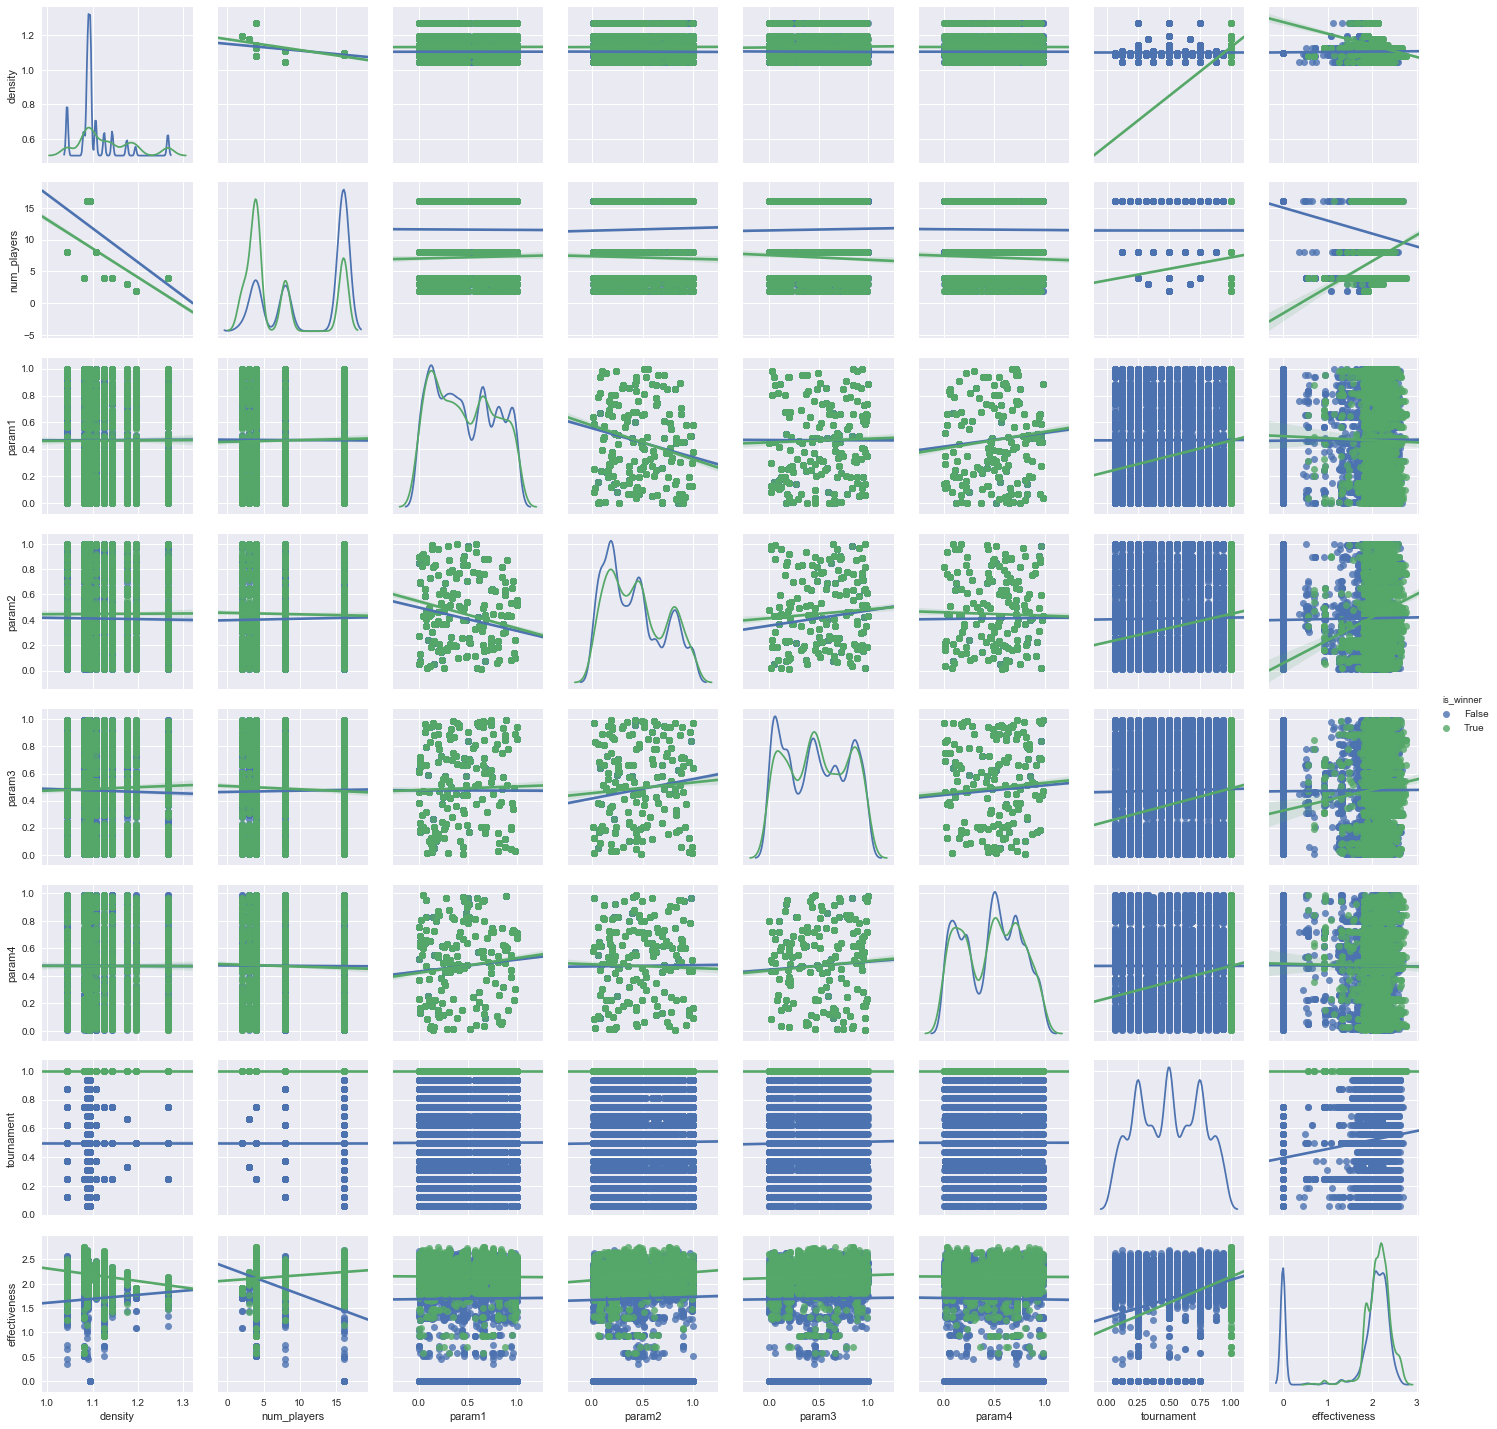

In [15]:
sns.pairplot(data, vars = major + params + ['tournament','effectiveness'],  hue = 'is_winner',
             kind='reg',
            diag_kind='kde',
            plot_kws={ 'scatter_kws' : {'alpha' : 0.8}})

In [16]:

test = data.loc[:  , major+params+['game_number','ranking']]
test = pd.merge(left=test,right=test,left_on='game_number',right_on='game_number',how='inner')
test = test.loc[test.ranking_x!=test.ranking_y]
test['x_wins'] = np.where(test.ranking_x<test.ranking_y,1,0)

features = [p+"_"+l for p in params for l in ['x','y']] + [p+"_x" for p in major]


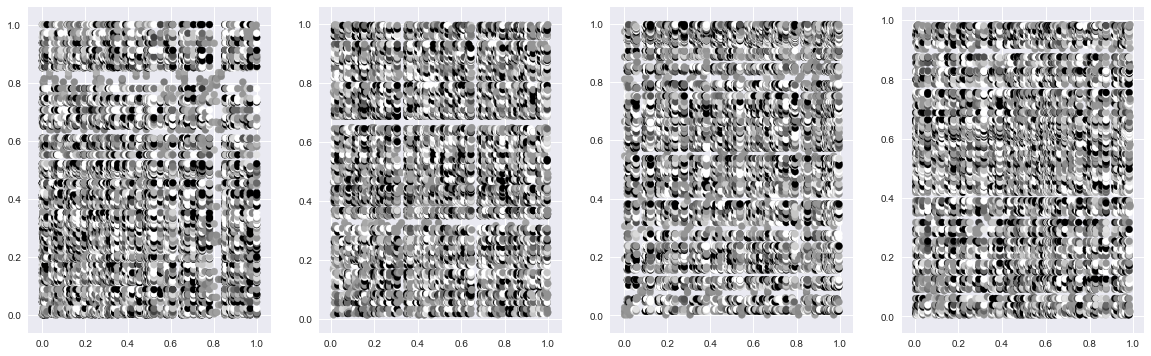

In [17]:
fix, ax = plt.subplots(1,len(params),figsize=(20,6))
for index, param in enumerate(params):
    grs = test.groupby([param+'_x',param+'_y']).mean()['x_wins'].reset_index()
    ax[index].scatter(grs[param+"_x"],grs[param+"_y"],c=grs.x_wins)

In [18]:
model = XGBClassifier()
model.fit(test[features],test.x_wins)

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

In [19]:
list(zip(features,model.feature_importances_))


[('param1_x', 0.11285714),
 ('param1_y', 0.098571427),
 ('param2_x', 0.079999998),
 ('param2_y', 0.081428573),
 ('param3_x', 0.090000004),
 ('param3_y', 0.084285714),
 ('param4_x', 0.094285712),
 ('param4_y', 0.094285712),
 ('density_x', 0.2),
 ('num_players_x', 0.064285718)]

In [20]:
from sklearn.model_selection import cross_val_score
cross_val_score(XGBClassifier(),test[features],test.x_wins)

array([ 0.50431743,  0.50990469,  0.50766381])